This notebook processes our final aggregation logic.

The flow of our approach is as follows:
- ignore document-query pairs with only one relevance label
- identify contradictory document-query relevance labels and exclude these
- calculate the ratio per user of provided relevanceCharacterRanges / total number of provided relevance labels
- assign weights based on above ratio and aggregate final relevance label by document-query pairs

At the end we analyze the results of the aggregation, by randomly picking some examples and conducting a meta-judgement of the raw-judgements + the quality of the aggregations based on the text contents of query and passage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Read baseline qrels file
baseline_qrels_df = pd.read_csv("Part-1/fira-22.baseline-qrels.tsv", sep="\t", encoding='utf-8')
# Read documents file
documents_df = pd.read_csv("Part-1/fira-22.documents.tsv", sep="\t", encoding='utf-8')
# Read judgements file
judgements_df = pd.read_csv("Part-1/fira-22.judgements-anonymized.tsv", sep="\t",encoding='utf-8')
# Read queries file
queries_df = pd.read_csv("Part-1/fira-22.queries.tsv", sep="\t",encoding='utf-8')

First we check which query-document pairs have contradictory labelling. Contradictory is defined as having at least one user label not being from '0_NOT_RELEVANT' or '1_TOPIC_RELEVANT_DOES_NOT_ANSWER'. 

In [10]:
mapping_relevance = {
    '0_NOT_RELEVANT': 0,
    '1_TOPIC_RELEVANT_DOES_NOT_ANSWER': 0,
    '2_GOOD_ANSWER': 1,
    '3_PERFECT_ANSWER': 1
}

def is_contradictory(judgements, mapping_relevance):
    judgements_binary = list(judgements['relevanceLevel'].map(mapping_relevance))
    return int(0 in judgements_binary and 1 in judgements_binary)

flag_is_contradictory = judgements_df.groupby(by = ['queryId', 'documentId']).apply(lambda x: is_contradictory(x, mapping_relevance)).reset_index()
flag_is_contradictory.columns = ['queryId', 'documentId', 'contradictory']

In [11]:
print("Number of query-document pairs: ", judgements_df.groupby(by = ['queryId', 'documentId']).count()['id'].count())

Number of query-document pairs:  24189


In [12]:
#filter out query-document pairs with only one voting
judgements_df = judgements_df.groupby(['documentId', 'queryId']).filter(lambda x: len(x) > 1)
#filter out query-document pairs with contradictory voting
judgements_df = judgements_df.merge(flag_is_contradictory, on=['queryId', 'documentId']).query('contradictory == 0')
print("Number of query-document pairs: ", judgements_df.groupby(by = ['queryId', 'documentId']).count()['id'].count())

Number of query-document pairs:  11716


## Reliability based on additional relevanceCharacterRanges
The assumption to be investigated here, is that users that provide also relevanceCharacterRanges are more reliable in their answers and therefore, they should receive higher weight. For this analysis we use only samples which received at least one relevanceCharacterRanges by any user.

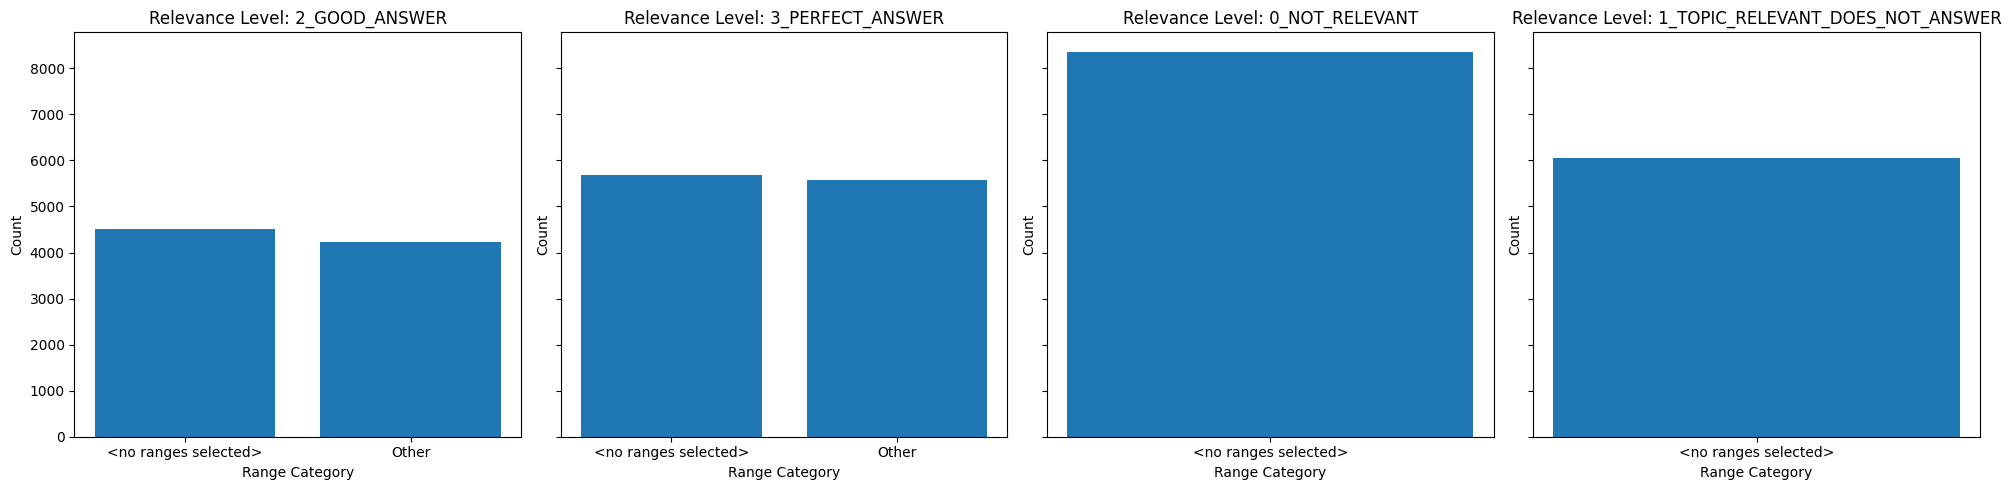

In [13]:
# Categorize the relevanceCharacterRanges
judgements_df['Range Category'] = judgements_df['relevanceCharacterRanges'].apply(
    lambda x: '<no ranges selected>' if x == '<no ranges selected>' else 'Other')

# Unique relevance levels in the data
relevance_levels = judgements_df['relevanceLevel'].unique()

# Create a figure and axes
fig, axs = plt.subplots(1, len(relevance_levels), figsize=(20, 5), sharey=True)

# Check if there's only one relevance level (in which case axs is not an array)
if len(relevance_levels) == 1:
    axs = [axs]

# Plot a histogram for each relevance level
for ax, level in zip(axs, relevance_levels):
    # Filter data for the current relevance level
    data = judgements_df[judgements_df['relevanceLevel'] == level]
    
    # Count the occurrences of each category
    counts = data['Range Category'].value_counts()
    
    # Plot
    ax.bar(counts.index, counts.values)
    ax.set_title(f'Relevance Level: {level}')
    ax.set_xlabel('Range Category')
    ax.set_ylabel('Count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Only for '2_GOOD_ANSWER', '3_PERFECT_ANSWER' a relevanceCharacterRanges is given. Focus only on these.

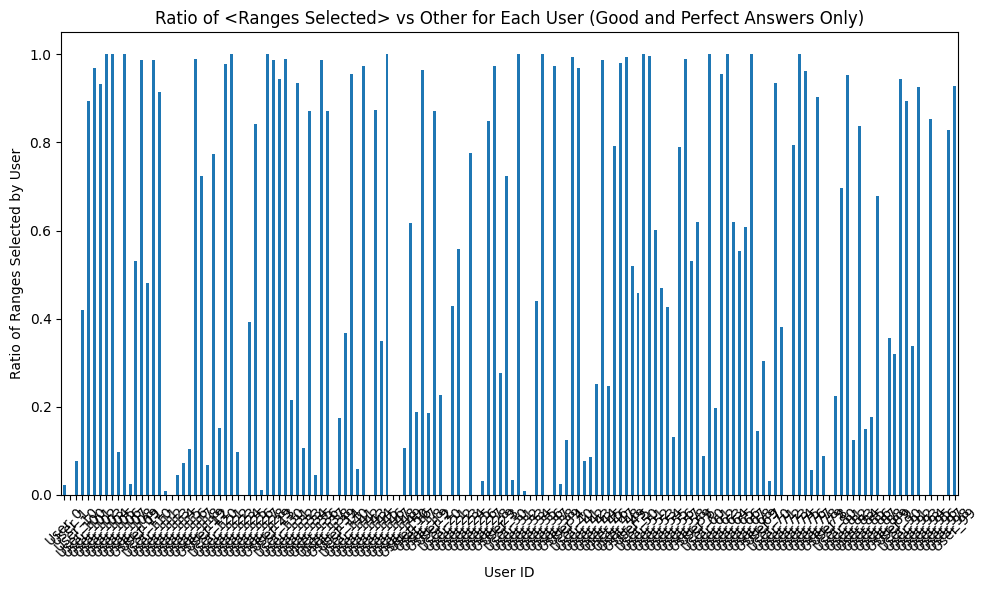

In [14]:
all_no_ranges = judgements_df.groupby('queryId')['relevanceCharacterRanges'].apply(lambda x: (x == '<no ranges selected>').all())
# Filter out the queryIds where all relevanceCharacterRanges are '<no ranges selected>'
filtered_query_ids = all_no_ranges[~all_no_ranges].index
# Use this index to filter the original DataFrame
filtered_df = judgements_df[judgements_df['queryId'].isin(filtered_query_ids)]
# Filter the DataFrame for desired relevance levels
filtered_df = filtered_df[filtered_df['relevanceLevel'].isin(['2_GOOD_ANSWER', '3_PERFECT_ANSWER'])]

# Categorize the relevanceCharacterRanges
filtered_df['Range Category'] = filtered_df['relevanceCharacterRanges'].apply(
    lambda x: 'No Ranges Selected' if x == '<no ranges selected>' else 'Ranges Selected')

# Group by userId and Range Category and count occurrences
grouped = filtered_df.groupby(['userId', 'Range Category']).size().unstack(fill_value=0)

# Calculate the ratio of 'ranges selected' to '!= <no ranges selected>'
grouped['Ratio'] = grouped['Ranges Selected'] / (grouped['Ranges Selected'] + grouped['No Ranges Selected'])

# Sort the users by their ID for a consistent plotting order
grouped = grouped.sort_index()

# Create a bar plot of the ratio for each user
plt.figure(figsize=(10, 6))
grouped['Ratio'].plot(kind='bar')
plt.title('Ratio of <Ranges Selected> vs Other for Each User (Good and Perfect Answers Only)')
plt.xlabel('User ID')
plt.ylabel('Ratio of Ranges Selected by User')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

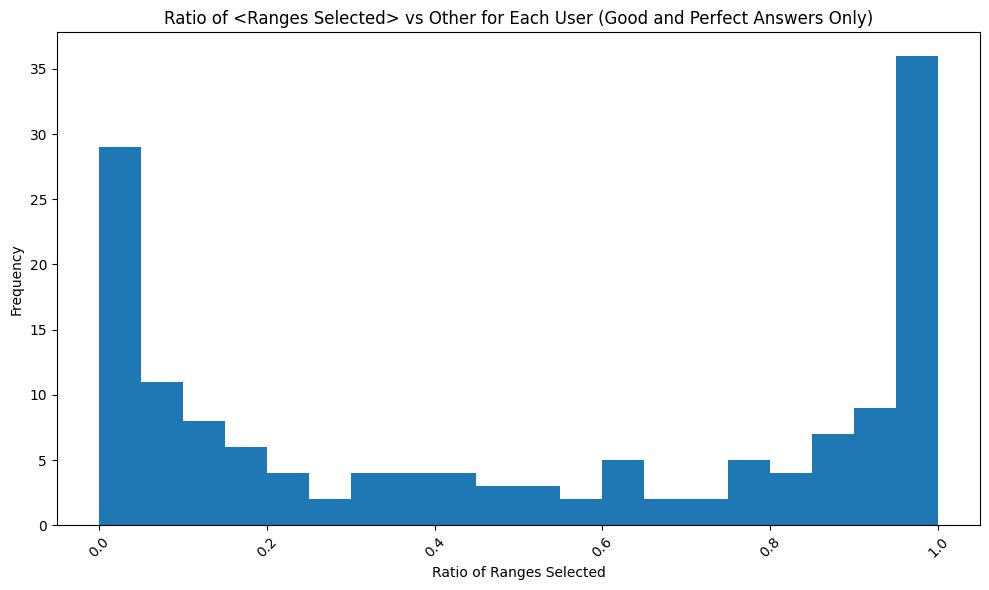

In [15]:
# Create a histogram plot of the ratio for each user
plt.figure(figsize=(10, 6))
grouped['Ratio'].plot(kind='hist', bins=20)
plt.title('Ratio of <Ranges Selected> vs Other for Each User (Good and Perfect Answers Only)')
plt.xlabel('Ratio of Ranges Selected')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Final aggregation setup

### Calculate aggregated labels with higher weights for reliable users (based on relevanceCharacterRanges)

Users with ratio >= 2/3 gets a weight of 2, users below a ratio <1/3 gets a weight 0.5, and rest gets 1 as a weight.

In [16]:
# Initial DataFrame setup
judgements = judgements_df[['relevanceLevel', 'documentId', 'queryId', 'userId']]

# Do a mapping to replace the values of the column relevanceLevel to values from 0-3
mapping = {
    '0_NOT_RELEVANT': 0,
    '1_TOPIC_RELEVANT_DOES_NOT_ANSWER': 1,
    '2_GOOD_ANSWER': 2,
    '3_PERFECT_ANSWER': 3
}
judgements['relevanceLevel'] = judgements['relevanceLevel'].map(mapping)

judgements = judgements.merge(grouped[['Ratio']], on='userId')
judgements['weight'] = judgements['Ratio'].apply(lambda x: 2 if x >= 2/3 else 0.5 if x < 1/3 else 1)

# Function to calculate the weighted average
def weighted_avg(group):
    return round((group['relevanceLevel'] * group['weight']).sum() / group['weight'].sum())

# Group by 'documentId' and 'queryId', then calculate the weighted average of 'relevanceLevel'
weighted_judgements = judgements.groupby(['documentId', 'queryId']).apply(weighted_avg).reset_index(name='weightedRelevanceLevel')

weighted_judgements


C:\Users\a96b3nc\AppData\Local\Temp\ipykernel_2796\2089508883.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judgements['relevanceLevel'] = judgements['relevanceLevel'].map(mapping)


,documentId,queryId,weightedRelevanceLevel
0,db_<dbpedia:...That's_the_Way_It_Is>,db_q_<dbpedia:...That's_the_Way_It_Is>,3
1,db_<dbpedia:1041>,db_q_<dbpedia:House_at_1141_North_Chester_Avenue>,0
2,db_<dbpedia:14th_FAI_World_Rally_Flying_Champi...,db_q_<dbpedia:10th_FAI_World_Rally_Flying_Cham...,2
3,db_<dbpedia:1564_in_India>,db_q_<dbpedia:1564_in_Norway>,0
4,db_<dbpedia:15th_FAI_World_Precision_Flying_Ch...,db_q_<dbpedia:10th_FAI_World_Rally_Flying_Cham...,2
...,...,...,...
11711,trip_9970279,trip_261512,0
11712,trip_9972958,trip_630551,0
11713,trip_997675,trip_17886,3
11714,trip_9986498,trip_26218,1


In [17]:
# Final creation of the data set that is going to be used in the second exercise
# The format of this data set will be similar to the baseline, provided by the instructions of the exercise
# Example 1: rob_q_FBIS3-10909 Q0 rob_FBIS3-10909 2
# Example 2: rob_q_FT941-8917 Q0 rob_FBIS3-10383 1
# Etc... 
def format_row(row):
    return f"{row['queryId']} Q0 {row['documentId']} {int(row['weightedRelevanceLevel'])}"
    
final_df_exercise_1 = weighted_judgements.apply(format_row, axis=1)

print("Saving the final data frame for the 1st exercise as a .tsv file...")
filename = "Final_Exercise_1.tsv"
final_df_exercise_1.to_csv(filename, sep='\t', index=False, header=False)
print("New TSV file saved successfully.")

Saving the final data frame for the 1st exercise as a .tsv file...
New TSV file saved successfully.


## Analyze the results of the aggregation

In [18]:
# comparison with majority voting
# Function to calculate majority vote
def majority_vote(group):
    return group['relevanceLevel'].mode()[0]  # Get the mode (most common value)

majority_judgements = judgements.groupby(['documentId', 'queryId']).apply(majority_vote).reset_index(name='majorityRelevanceLevel')
# Merging the results
compare_judgements = pd.merge(weighted_judgements, majority_judgements, on=['documentId', 'queryId'])

# Create cross tabulation
pd.crosstab(compare_judgements['weightedRelevanceLevel'], compare_judgements['majorityRelevanceLevel'])

majorityRelevanceLevel,0,1,2,3
weightedRelevanceLevel,,,,
0,2728,151,0,0
1,167,1819,0,0
2,0,0,2792,384
3,0,0,245,3430


In the above cross-table we compare the simple aggregation logic to our setup. As expected some differences in labeling is present, but these are limited. Differences are approx. 8%. On the top-roght and bottom-left no entries are given as we excluded contradictory votings.

In [19]:
#randomly pick some examples and conduct a meta-judgement of the raw-judgements
random_sample = weighted_judgements.sample(n=10, random_state=1)
random_sample

,documentId,queryId,weightedRelevanceLevel
9264,trip_891241,trip_87746,2
2525,rob_FBIS4-21196,rob_qq_FBIS4-21196,3
7606,trip_476842,trip_1596149,0
589,db_<dbpedia:Fiji_Rugby_Union>,db_q_<dbpedia:Semi_Kunatani>,1
5329,rob_LA121590-0145,rob_qq_FT932-3670,0
551,db_<dbpedia:Enemies:_How_America's_Foes_Steal_...,db_q_<dbpedia:How_it_Happens>,1
586,db_<dbpedia:Felix_the_Cat>,db_q_<dbpedia:The_Deluge_(film)>,1
384,db_<dbpedia:Christine_Edwards>,db_q_<dbpedia:Christine_Panushka>,0
4298,rob_FT943-12053,rob_q_FT942-13354,3
1139,"db_<dbpedia:Mansfield_High_School_(Mansfield,_...",db_q_<dbpedia:Mansfield_Street>,0


In [21]:
merged_df = pd.merge(judgements_df, documents_df, left_on='documentId', right_on='doc_id')
# Function to extract text based on character ranges
def extract_relevant_text(row):
    if row['relevanceCharacterRanges'] == '<no ranges selected>':
        return '<no ranges selected>'
    ranges = row['relevanceCharacterRanges'].split(';')
    relevant_texts = []
    for r in ranges:
        start, end = map(int, r.split('-'))
        relevant_texts.append(row['doc_text'][start:end])
    return ' '.join(relevant_texts)

# Apply the function to extract relevant text passages
merged_df['relevant_text'] = merged_df.apply(extract_relevant_text, axis=1)

# Select only the necessary columns
doc_passage = merged_df[['documentId', 'queryId', 'userId', 'relevant_text']]

In the following some *random* examples of aggregated labeling is presented. Each example presents the users label, aggregated label, the annotated text of the user (if available), and the query text.

In [22]:
judgements.merge(random_sample.iloc[[0]], on=['documentId', 'queryId']).merge(queries_df, left_on='queryId', right_on='query_id').merge(doc_passage, on=['documentId', 'queryId', 'userId'])

,relevanceLevel,documentId,queryId,userId,Ratio,weight,weightedRelevanceLevel,query_id,query_text,relevant_text
0,3,trip_891241,trip_87746,User_14,0.173516,0.5,2,trip_87746,nocturnal enuresis children,<no ranges selected>
1,3,trip_891241,trip_87746,User_24,0.000000,0.5,2,trip_87746,nocturnal enuresis children,<no ranges selected>
2,2,trip_891241,trip_87746,User_71,0.934211,2.0,2,trip_87746,nocturnal enuresis children,wet nights


In [41]:
judgements.merge(random_sample.iloc[[1]], on=['documentId', 'queryId']).merge(queries_df, left_on='queryId', right_on='query_id').merge(doc_passage, on=['documentId', 'queryId', 'userId'])

,relevanceLevel,documentId,queryId,userId,Ratio,weight,weightedRelevanceLevel,query_id,query_text,relevant_text
0,3,rob_FBIS4-21196,rob_qq_FBIS4-21196,User_23,0.557447,1.0,3,rob_qq_FBIS4-21196,What agency is Haiti's anti-drug service work...,<no ranges selected>
1,3,rob_FBIS4-21196,rob_qq_FBIS4-21196,User_60,0.088398,0.5,3,rob_qq_FBIS4-21196,What agency is Haiti's anti-drug service work...,working jointly with the local branch of the u...


In [42]:
judgements.merge(random_sample.iloc[[2]], on=['documentId', 'queryId']).merge(queries_df, left_on='queryId', right_on='query_id').merge(doc_passage, on=['documentId', 'queryId', 'userId'])

,relevanceLevel,documentId,queryId,userId,Ratio,weight,weightedRelevanceLevel,query_id,query_text,relevant_text
0,0,trip_476842,trip_1596149,User_23,0.557447,1.0,0,trip_1596149,Diagnosis Mental or psychiatric or stability o...,<no ranges selected>
1,0,trip_476842,trip_1596149,User_72,0.381443,1.0,0,trip_1596149,Diagnosis Mental or psychiatric or stability o...,<no ranges selected>
2,0,trip_476842,trip_1596149,User_39,0.025000,0.5,0,trip_1596149,Diagnosis Mental or psychiatric or stability o...,<no ranges selected>


In [43]:
judgements.merge(random_sample.iloc[[3]], on=['documentId', 'queryId']).merge(queries_df, left_on='queryId', right_on='query_id').merge(doc_passage, on=['documentId', 'queryId', 'userId'])

,relevanceLevel,documentId,queryId,userId,Ratio,weight,weightedRelevanceLevel,query_id,query_text,relevant_text
0,1,db_<dbpedia:Fiji_Rugby_Union>,db_q_<dbpedia:Semi_Kunatani>,User_7,0.302885,0.5,1,db_q_<dbpedia:Semi_Kunatani>,whats the name of fiji rugby player,<no ranges selected>
1,1,db_<dbpedia:Fiji_Rugby_Union>,db_q_<dbpedia:Semi_Kunatani>,User_75,1.000000,2.0,1,db_q_<dbpedia:Semi_Kunatani>,whats the name of fiji rugby player,<no ranges selected>
2,1,db_<dbpedia:Fiji_Rugby_Union>,db_q_<dbpedia:Semi_Kunatani>,User_98,0.829268,2.0,1,db_q_<dbpedia:Semi_Kunatani>,whats the name of fiji rugby player,<no ranges selected>


In [44]:
judgements.merge(random_sample.iloc[[8]], on=['documentId', 'queryId']).merge(queries_df, left_on='queryId', right_on='query_id').merge(doc_passage, on=['documentId', 'queryId', 'userId'])

,relevanceLevel,documentId,queryId,userId,Ratio,weight,weightedRelevanceLevel,query_id,query_text,relevant_text
0,3,rob_FT943-12053,rob_q_FT942-13354,User_52,0.996032,2.0,3,rob_q_FT942-13354,coca cola moscow,cola claims to be the dominant western produce...
1,2,rob_FT943-12053,rob_q_FT942-13354,User_14,0.173516,0.5,3,rob_q_FT942-13354,coca cola moscow,the inchcape franchises are in six of the 12 l...
2,3,rob_FT943-12053,rob_q_FT942-13354,User_20,0.227273,0.5,3,rob_q_FT942-13354,coca cola moscow,<no ranges selected>


In the following we selected some cases where the simple aggregation and our approach concluded differently. Especially, here the different treatments between the two approaches are visible. E.g., if a highly reliable person labels the query-document pair with 2_GOOD_ANSWER and provides a sensible relevance character range and the other two users label it with 3_PERFECT_ANSWER but do not provide a relevance character range we believe the first user is more reliable and his opinion is more important.

In [45]:
random_sample = compare_judgements.loc[compare_judgements['weightedRelevanceLevel'] != compare_judgements['majorityRelevanceLevel']].sample(n=10, random_state=1)
random_sample

,documentId,queryId,weightedRelevanceLevel,majorityRelevanceLevel
3735,rob_FT931-6721,rob_qq_FT941-8236,0,1
10611,trip_9368493,trip_58912,2,3
6127,trip_11039115,trip_187518,3,2
9361,trip_8954099,trip_65051,2,3
8050,trip_5260675,trip_54317,2,3
4556,rob_LA020490-0070,rob_q_FT941-17453,3,2
10799,trip_9418709,trip_116082,2,3
9927,trip_9236217,trip_12073,3,2
578,db_<dbpedia:Extensive_Bracken_County_Area>,"db_q_<dbpedia:Harrison,_New_Jersey>",1,0
1261,db_<dbpedia:Namamugi_Incident>,db_q_<dbpedia:Namamugi_Station>,0,1


In [46]:
judgements.merge(random_sample.iloc[[1]], on=['documentId', 'queryId']).merge(queries_df, left_on='queryId', right_on='query_id').merge(doc_passage, on=['documentId', 'queryId', 'userId'])

,relevanceLevel,documentId,queryId,userId,Ratio,weight,weightedRelevanceLevel,majorityRelevanceLevel,query_id,query_text,relevant_text
0,3,trip_9368493,trip_58912,User_20,0.227273,0.5,2,3,trip_58912,depression music,<no ranges selected>
1,3,trip_9368493,trip_58912,User_79,0.088889,0.5,2,3,trip_58912,depression music,<no ranges selected>
2,2,trip_9368493,trip_58912,User_137,0.987805,2.0,2,3,trip_58912,depression music,music therapy for depression . background : de...


In [47]:
judgements.merge(random_sample.iloc[[2]], on=['documentId', 'queryId']).merge(queries_df, left_on='queryId', right_on='query_id').merge(doc_passage, on=['documentId', 'queryId', 'userId'])

,relevanceLevel,documentId,queryId,userId,Ratio,weight,weightedRelevanceLevel,majorityRelevanceLevel,query_id,query_text,relevant_text
0,2,trip_11039115,trip_187518,User_23,0.557447,1.0,3,2,trip_187518,binge eating disorder,impuls : impulsivity - focused group intervent...
1,3,trip_11039115,trip_187518,User_68,1.000000,2.0,3,2,trip_187518,binge eating disorder,focused group intervention to reduce binge eat...
2,2,trip_11039115,trip_187518,User_77,0.056338,0.5,3,2,trip_187518,binge eating disorder,<no ranges selected>


In [48]:
judgements.merge(random_sample.iloc[[3]], on=['documentId', 'queryId']).merge(queries_df, left_on='queryId', right_on='query_id').merge(doc_passage, on=['documentId', 'queryId', 'userId'])

,relevanceLevel,documentId,queryId,userId,Ratio,weight,weightedRelevanceLevel,majorityRelevanceLevel,query_id,query_text,relevant_text
0,3,trip_8954099,trip_65051,User_20,0.227273,0.5,2,3,trip_65051,family witnessed resuscitation,<no ranges selected>
1,3,trip_8954099,trip_65051,User_50,0.459016,1.0,2,3,trip_65051,family witnessed resuscitation,<no ranges selected>
2,2,trip_8954099,trip_65051,User_127,0.840909,2.0,2,3,trip_65051,family witnessed resuscitation,family - witnessed resuscitation . giving fami...


In [49]:
judgements.merge(random_sample.iloc[[4]], on=['documentId', 'queryId']).merge(queries_df, left_on='queryId', right_on='query_id').merge(doc_passage, on=['documentId', 'queryId', 'userId'])

,relevanceLevel,documentId,queryId,userId,Ratio,weight,weightedRelevanceLevel,majorityRelevanceLevel,query_id,query_text,relevant_text
0,3,trip_5260675,trip_54317,User_77,0.056338,0.5,2,3,trip_54317,renal cell carcinoma,<no ranges selected>
1,2,trip_5260675,trip_54317,User_129,1.000000,2.0,2,3,trip_54317,renal cell carcinoma,hereditary papillary renal cell carcinoma prim...
2,3,trip_5260675,trip_54317,User_126,0.393258,1.0,2,3,trip_54317,renal cell carcinoma,papillary renal cell carcinoma is a rare cance...
